In [1]:
import os
os.chdir('/Users/xinglongli/git_local/sts-jax')

# Structural time series (STS) model with Poisson likelihood

In [2]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np

import sts_jax.structural_time_series.sts_model as sts

## Synthetic Data

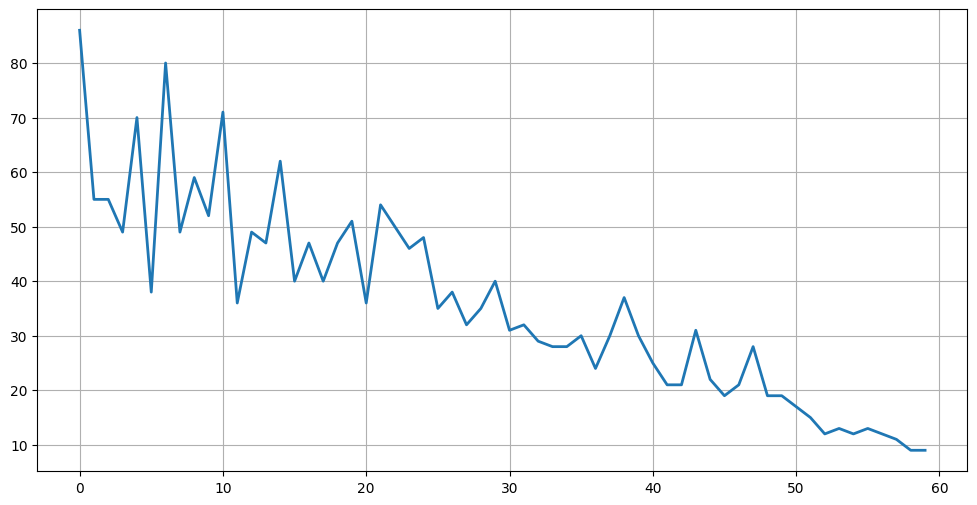

In [5]:
num_steps = 60
num_training_steps = 30
num_forecast_steps = num_steps - num_training_steps

np.random.seed(1)
counts = np.round(3 + np.random.lognormal(np.log(np.linspace(
    num_steps, 5, num=num_steps)), 0.2, size=num_steps))
counts = counts.astype(np.float32)
counts_training = counts[:num_training_steps]
plt.figure(figsize=(12, 6))
plt.plot(counts, lw=2)
plt.grid()

## Implementation via CMGF

In [6]:
counts = jnp.array(counts[:num_steps, None])
counts_training = counts[:num_training_steps]
counts_predict = counts[-num_forecast_steps:]

### Build the STS model

In [7]:
trend = sts.LocalLinearTrend()
model = sts.StructuralTimeSeries([trend],
                                 obs_distribution='Poisson',
                                 obs_time_series=counts_training)

### Model fitting

In [8]:
# Fit the model using HMC
obs_time_series = counts_training
key = jr.PRNGKey(0)

In [10]:
parameter_samples, _losses = model.fit_mle(obs_time_series, num_steps=1000)

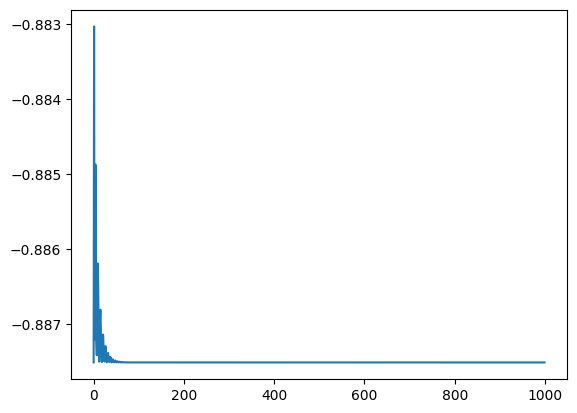

In [11]:
plt.plot(jnp.log(_losses))

### Forecast

In [12]:
forecasts = model.forecast(parameter_samples, obs_time_series, num_forecast_steps)

In [16]:
forecast_means = jnp.squeeze(forecasts['means'])


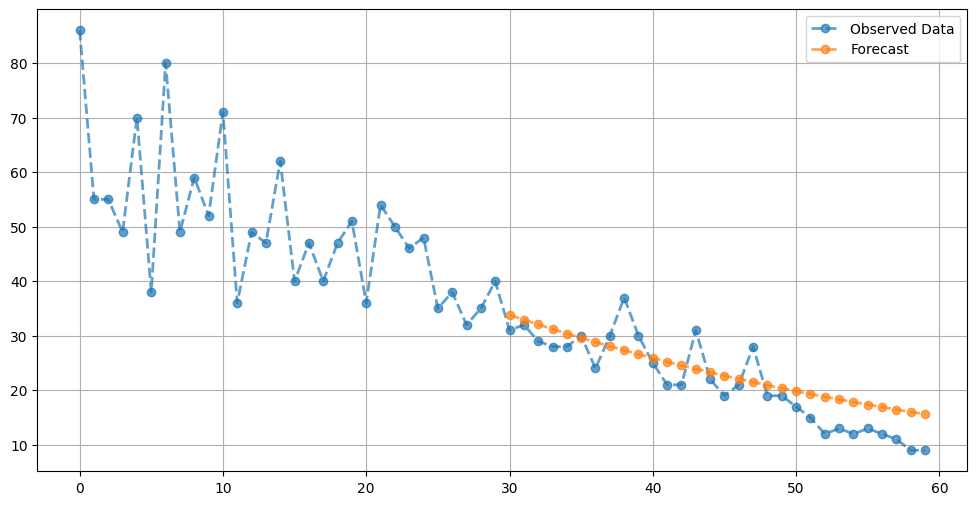

In [17]:
# CI = 90
# CI_interval = jnp.array([(100 - CI)/2, 100 - (100 - CI)/2])
# lower, upper = jnp.percentile(jnp.squeeze(forecasts['means']), CI_interval, axis=0)
# forecast_scale = jnp.std(jnp.squeeze(forecasts['means']), axis=0)

# Plot the prediction
time_steps = jnp.arange(num_steps)
time_steps_forecast = time_steps[-num_forecast_steps:]

fig = plt.figure(figsize=(12, 6))
plt.plot(time_steps, counts, lw=2, linestyle='--', marker='o',
         color='C0', alpha=0.7, label='Observed Data')
plt.plot(time_steps_forecast, forecast_means, lw=2, linestyle='--', marker='o',
         color='C1', alpha=0.7, label='Forecast')
# plt.fill_between(time_steps_forecast, lower, upper, color='orange', alpha=0.3)
# plt.fill_between(time_steps_forecast, forecast_means-2*forecast_scale, forecast_means+2*forecast_scale, color='orange', alpha=0.3)
plt.grid()
plt.legend()